In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import sys

import warnings

warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore")

# 定义要处理的模型(YOLOv8n目标检测模型)

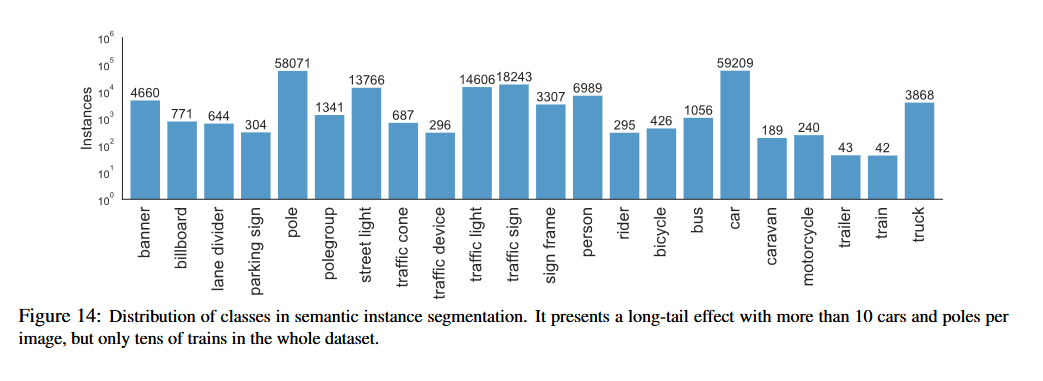

In [ ]:
yolo = YOLO(model='./models/yolov8-bdd100k.pt')
yolo = yolo.cuda()
yolo.info(detailed=True)
print(yolo.names)
results = yolo(source="./images/img_2.jpg")
for result in results:
	print(result[0].boxes.cls)
	# result.show()
results = yolo(source="./images/perturbed_img_2.jpg")
for result in results:
	print(result[0].boxes.cls)
	# result.show()

选择要处理的层

In [ ]:
yolo.info(detailed=True)
yolo_model = yolo.model
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
yolo_model = yolo_model.to(device).eval()
for param in yolo_model.parameters():
	param.requires_grad = False  # 冻结模型参数

选择要进行CAM操作的目标层,暂时只检查backbone

In [ ]:
yolo_nn = yolo_model.model
layer_map = {
	# 如果要选择其他c2f输出,只需要更改这个字典
	"backbone_c2f1": 2,
	"backbone_c2f2": 4,
	"backbone_c2f3": 6,
	"backbone_c2f4": 8, 
	"backbone_sppf": 9,
	"neck_c2f1": 12,
	"neck_c2f2": 15,
	"neck_c2f3": 18,
	"neck_c2f4": 21
}

layers = {layer: yolo_nn[idx] for layer, idx in layer_map.items()}

In [ ]:
# 加载YOLO模型（以v8为例）
neck_c2f3 = yolo_nn[layer_map['neck_c2f3']]
# print(neck_c2f3)
# 存储特征图的字典
features = {}
target_conv = []

# 定义钩子函数：保存当前层输出
def hook_fn(module, input, output, path) -> None:
	features[path] = output

# 遍历c2f中的所有子模块
def register_hooks(module, parent_path="") -> None:
	for name, child in module.named_children():
		current_path = f"{parent_path}.{name}" if parent_path else name
		if isinstance(child, torch.nn.Conv2d):
			child.register_forward_hook(hook=lambda m, i, o, path=current_path: hook_fn(module=m, input=i, output=o, path=path))
		else:
			register_hooks(module=child, parent_path=current_path)

print('layers in module:\'neck_c2f3\'')    
register_hooks(module=neck_c2f3, parent_path="neck_c2f3")

# 归一化每个通道到[0, 255]（灰度图）
def normalize(feature):
	feature = feature - feature.min()
	feature = feature / (feature.max() + 1e-8)
	return (feature * 255).byte().cpu().numpy()
	 
# 输入测试数据触发前向传播
output = yolo(source='./images/perturbed_img_2.jpg')
# 提取特征图（features字典中保存了各卷积层的输出）
print('feature size in each layer')
for path, feature in features.items():
	print(f"{path}: {feature.shape}")
	 # 选择batch维度的第一个元素
	feature = feature.squeeze(0)
	# 选择要可视化的通道（示例：前8个通道）
	num_vis = 8  # 可调整为其他数量（如16）
	selected_channels = feature[:num_vis]  # 或按响应值排序后选择

	# 可视化
	# fig, axes = plt.subplots(1, num_vis, figsize=(20, 5))
	# for i, (ax, channel) in enumerate(zip(axes, selected_channels)):
	#     # 归一化并转为二维图像
	#     img = normalize(channel)
	#     # 显示灰度图（或用cmap='viridis'显示伪彩色）
	#     ax.imshow(img, cmap='gray')
	#     ax.set_title(f'Channel {i+1}')
	#     ax.axis('off')
	# plt.tight_layout()
	# plt.show()

In [ ]:
from functools import partial
import torchvision.transforms as T

class SaveFeatures:
	def __init__(self) -> None:
		self.features = {}
		self.hooks = []
	def hook_fn(self, module, input, output, path) -> None:
		self.features[path] = output
	def register_hooks(self, module, parent_path) -> None:
		for name, child in module.named_children():
			current_path = f"{parent_path}.{name}" if parent_path else name
			if isinstance(child, torch.nn.Conv2d):
				# 使用partial绑定self和path参数
				hook = child.register_forward_hook(
					hook=partial(self.hook_fn, path=current_path)
				)
				self.hooks.append(hook)  # 保存钩子以便后续移除
			else:
				# 递归处理子模块
				self.register_hooks(module=child, parent_path=current_path)
	def get_features(self):
		return self.features
	def close(self):
		for hook in self.hooks:
			hook.remove()
		self.hooks.clear()

class FilterAnalyzer():
	def __init__(self, model, module, parent_path):
		self.model, self.module, self.parent_path = model, module, parent_path
		self.model.model.train()
		self.save_features = SaveFeatures()
		self.save_features.register_hooks(module=self.module, parent_path=self.parent_path)
		
	def get_yolo_transforms(self, sz: int):
		val_tfms = T.Compose(transforms=[
			T.ToTensor(),
			T.Resize(size=(sz, sz)),
		])
		train_tfms = val_tfms
		return train_tfms, val_tfms
	
	def denorm(self, tensor: torch.Tensor) -> np.ndarray:
		"""反归一化：将 [0,1] 张量恢复为 [0,255] 图像（HWC）"""
		img = tensor.permute(1, 2, 0).cpu().numpy() * 255
		return np.clip(img, 0, 255).astype(np.uint8)
	
	# def visualize_opt(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
	def visualize_opt(self, target_layer_path, size=56, upscaling_steps=12, upscaling_factor=1.2,
					  filter_idx=0, lr=0.1, opt_steps=20, blur=None, cmd=False) -> None:   
		loss = 0
		sz = size  
		img = np.float32(np.random.uniform(low=150, high=180, size=(sz, sz, 3))/255)
		train_tfms, val_tfms = self.get_yolo_transforms(sz=sz)
		img_tensor = val_tfms(img=img).unsqueeze(0)  # type: ignore # [1, 3, sz, sz]
		img_var = torch.tensor(data=img_tensor, requires_grad=True, device=self.model.device, dtype=torch.float32)
		for step in range(upscaling_steps):
			# print(f"upscaling step{step+1}")
			# 步骤3：初始化优化器（优化图像像素值）
			optimizer = torch.optim.Adam(params=[img_var], lr=lr, weight_decay=1e-6)
			# 步骤4：优化像素值（最大化目标 filter 的激活）
			for n in range(opt_steps):
				optimizer.zero_grad()
				_ = self.model.model(img_var)  # YOLOv8 前向传播（输出可能包含多个特征图，但钩子仅捕获目标层）
				activations = self.save_features.get_features()
				target_features = activations[target_layer_path]
				if target_features is None:
					raise ValueError(f"未找到目标层特征，路径：{target_layer_path}")
				loss = -target_features[0, filter_idx].mean()  # [0, filter_idx] 对应 batch 0，第 filter_idx 个通道
				loss.backward()
				optimizer.step()
			if cmd:
				print(f"loss in epoch{step+1}: {loss}")
			# 步骤5：反归一化并恢复图像（HWC, [0,255]）
			img = self.denorm(img_var.detach().squeeze(0))  # [3, sz, sz] → [sz, sz, 3]
			# print(img)
			self.output = img
			# 步骤6：上采样图像（为下一轮优化准备更大尺寸）
			sz = int(upscaling_factor * sz)
			img = cv2.resize(img, (sz, sz), interpolation=cv2.INTER_CUBIC)  # 上采样
			if blur is not None:
				img = cv2.blur(img, (blur, blur))  # 模糊去高频噪声
			# plt.imshow(X=np.clip(a=self.output, a_min=0, a_max=1))
		file_name = "./filter/"+str(object=target_layer_path)+"_filter_"+str(object=filter_idx+1)+".jpg"
		print(f"save: {file_name}")
		plt.imsave(fname="./filter/layer_"+str(object=target_layer_path)+"_filter_"+str(object=filter_idx+1)+".jpg", arr=self.output)
		if cmd:  
			plt.imshow(X=self.output)
			
	def compute_single_mean_activation(self, img_path, target_layer_path, left_filter_idx, right_filter_idx , size=640):
		img = cv2.imread(img_path)
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
		img = np.float32(cv2.resize(img, (size, size))/255)
	
		# 2. 应用YOLO的数据增强（验证模式）
		_, val_tfms = self.get_yolo_transforms(sz=size)
		img_tensor = val_tfms(img=img).unsqueeze(0)  # [1, 3, sz, sz]
		img_var = torch.tensor(data=img_tensor, requires_grad=True, device=self.model.device, dtype=torch.float32)
		
		with torch.no_grad():
			_ = self.model.model(img_var)  # YOLOv8 前向传播（输出可能包含多个特征图，但钩子仅捕获目标层）
			activations = self.save_features.get_features()
			target_features = activations[target_layer_path][0, left_filter_idx:right_filter_idx, :, :]
			mean_activation = target_features.mean(axis=[1, 2]).cpu().detach().numpy()
		
		# 绘制单图
		# plt.figure(figsize=(len(filter_idx)/4, 5))
		# filter_num = right_filter_idx - left_filter_idx
		# plt.bar(range(filter_num), mean_activation, color='blue', alpha=1)
		# plt.title(f'Mean Activation per Filter: {target_layer_path}')
		# plt.xlabel('Filter Index')
		# plt.ylabel('Activation Magnitude')
		# plt.xticks(np.arange(0, filter_num, max(1, filter_num//10)))  # 自动调整刻度密度
		# plt.grid(axis='y', linestyle='--', alpha=0.5)
		# plt.tight_layout()
		# plt.show()
		
		mean_activation = torch.from_numpy(mean_activation).to(device=self.model.device, dtype=torch.float32)
		
		return mean_activation

**可以修改的参数,除这些外不要动:**

- `module`:要查看的model各层模块,命名方式如前面`layer_map`;
- `target_layer_path`:model模块中的具体层,命名方式参考上一个代码块;
- `parent_path`:与`module`保持一致即可,是`str`格式;
- `size`:输入图片变形后的大小,原始值为`640`;
- `upscaling_steps`:上采样步长,不能无限增大,太多次上采样会导致图片尺寸变大,显存会爆炸;
- `filter_idx`:选择输出的卷积核序号;
- `opt_steps`:每次上采样迭代中的优化器迭代次数;
- `blur`:最终绘图时的高斯模糊尺度;
- `cmd`:是否输出中间结果,仅调试时用.

选择`target_layer_path`时,参考模型结构即可,下面的模型结构节选自`yolo.info(detail=True)`的`backbone_c2f4`输出结果.

如果要选择`backbone_c2f4`第二个卷积块中的卷积层,设置`target_layer_path='backbone_c2f3.cv1.conv'`即可,其他的也按照这个标准来.


```
C2f(
	(cv1): Conv(
		(conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
		(act): SiLU(inplace=True)
	)
	(cv2): Conv(
		(conv): Conv2d(1152, 384, kernel_size=(1, 1), stride=(1, 1))
		(act): SiLU(inplace=True)
	)
	(m): ModuleList(
		(0-3): 4 x Bottleneck(
			(cv1): Conv(
				(conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
				(act): SiLU(inplace=True)
			)
			(cv2): Conv(
				(conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
				(act): SiLU(inplace=True)
			)
		)
	)
```

In [100]:
# 通道数 卷积核数 卷积核尺寸 卷积步长 补零尺寸
# Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
fa_backbone_c2f1 = FilterAnalyzer(model=yolo, module=yolo_nn[layer_map['backbone_c2f1']], parent_path='backbone_c2f1')
fa_backbone_c2f2 = FilterAnalyzer(model=yolo, module=yolo_nn[layer_map['backbone_c2f2']], parent_path='backbone_c2f2')
fa_backbone_c2f3 = FilterAnalyzer(model=yolo, module=yolo_nn[layer_map['backbone_c2f3']], parent_path='backbone_c2f3')
fa_backbone_c2f4 = FilterAnalyzer(model=yolo, module=yolo_nn[layer_map['backbone_c2f4']], parent_path='backbone_c2f4')
fa_neck_c2f1= FilterAnalyzer(model=yolo, module=yolo_nn[layer_map['neck_c2f1']], parent_path='neck_c2f1')
fa_neck_c2f2 = FilterAnalyzer(model=yolo, module=yolo_nn[layer_map['neck_c2f2']], parent_path='neck_c2f2')
fa_neck_c2f3 = FilterAnalyzer(model=yolo, module=yolo_nn[layer_map['neck_c2f3']], parent_path='neck_c2f3')
fa_neck_c2f4 = FilterAnalyzer(model=yolo, module=yolo_nn[layer_map['neck_c2f4']], parent_path='neck_c2f4')

def compute_all_mean_activation(img_path):
	activation = []
	activation.append(fa_backbone_c2f1.compute_single_mean_activation(img_path, 'backbone_c2f1.cv1.conv', 0, 32))
	activation.append(fa_backbone_c2f1.compute_single_mean_activation(img_path, 'backbone_c2f1.cv2.conv', 0, 32))
	activation.append(fa_backbone_c2f1.compute_single_mean_activation(img_path, 'backbone_c2f1.m.0.cv1.conv', 0, 16))
	activation.append(fa_backbone_c2f1.compute_single_mean_activation(img_path, 'backbone_c2f1.m.0.cv2.conv', 0, 16))
	activation.append(fa_backbone_c2f2.compute_single_mean_activation(img_path, 'backbone_c2f2.cv1.conv', 0, 64))
	activation.append(fa_backbone_c2f2.compute_single_mean_activation(img_path, 'backbone_c2f2.cv2.conv', 0, 64))
	activation.append(fa_backbone_c2f2.compute_single_mean_activation(img_path, 'backbone_c2f2.m.0.cv1.conv', 0, 32))
	activation.append(fa_backbone_c2f2.compute_single_mean_activation(img_path, 'backbone_c2f2.m.0.cv2.conv', 0, 32))
	activation.append(fa_backbone_c2f2.compute_single_mean_activation(img_path, 'backbone_c2f2.m.1.cv1.conv', 0, 32))
	activation.append(fa_backbone_c2f2.compute_single_mean_activation(img_path, 'backbone_c2f2.m.1.cv2.conv', 0, 32))
	activation.append(fa_backbone_c2f3.compute_single_mean_activation(img_path, 'backbone_c2f3.cv1.conv', 0, 128))
	activation.append(fa_backbone_c2f3.compute_single_mean_activation(img_path, 'backbone_c2f3.cv2.conv', 0, 128))
	activation.append(fa_backbone_c2f3.compute_single_mean_activation(img_path, 'backbone_c2f3.m.0.cv1.conv', 0, 64))
	activation.append(fa_backbone_c2f3.compute_single_mean_activation(img_path, 'backbone_c2f3.m.0.cv2.conv', 0, 64))
	activation.append(fa_backbone_c2f3.compute_single_mean_activation(img_path, 'backbone_c2f3.m.1.cv1.conv', 0, 64))
	activation.append(fa_backbone_c2f3.compute_single_mean_activation(img_path, 'backbone_c2f3.m.1.cv2.conv', 0, 64))
	activation.append(fa_backbone_c2f4.compute_single_mean_activation(img_path, 'backbone_c2f4.cv1.conv', 0, 256))
	activation.append(fa_backbone_c2f4.compute_single_mean_activation(img_path, 'backbone_c2f4.cv2.conv', 0, 256))
	activation.append(fa_backbone_c2f4.compute_single_mean_activation(img_path, 'backbone_c2f4.m.0.cv1.conv', 0, 128))
	activation.append(fa_backbone_c2f4.compute_single_mean_activation(img_path, 'backbone_c2f4.m.0.cv2.conv', 0, 128))
	activation.append(fa_neck_c2f1.compute_single_mean_activation(img_path, 'neck_c2f1.cv1.conv', 0, 128))
	activation.append(fa_neck_c2f1.compute_single_mean_activation(img_path, 'neck_c2f1.cv2.conv', 0, 128))
	activation.append(fa_neck_c2f1.compute_single_mean_activation(img_path, 'neck_c2f1.m.0.cv1.conv', 0, 64))
	activation.append(fa_neck_c2f1.compute_single_mean_activation(img_path, 'neck_c2f1.m.0.cv2.conv', 0, 64))
	activation.append(fa_neck_c2f2.compute_single_mean_activation(img_path, 'neck_c2f2.cv1.conv', 0, 64))
	activation.append(fa_neck_c2f2.compute_single_mean_activation(img_path, 'neck_c2f2.cv2.conv', 0, 64))
	activation.append(fa_neck_c2f2.compute_single_mean_activation(img_path, 'neck_c2f2.m.0.cv1.conv', 0, 32))
	activation.append(fa_neck_c2f2.compute_single_mean_activation(img_path, 'neck_c2f2.m.0.cv2.conv', 0, 32))
	activation.append(fa_neck_c2f3.compute_single_mean_activation(img_path, 'neck_c2f3.cv1.conv', 0, 128))
	activation.append(fa_neck_c2f3.compute_single_mean_activation(img_path, 'neck_c2f3.cv2.conv', 0, 128))
	activation.append(fa_neck_c2f3.compute_single_mean_activation(img_path, 'neck_c2f3.m.0.cv1.conv', 0, 64))
	activation.append(fa_neck_c2f3.compute_single_mean_activation(img_path, 'neck_c2f3.m.0.cv2.conv', 0, 64))
	activation.append(fa_neck_c2f4.compute_single_mean_activation(img_path, 'neck_c2f4.cv1.conv', 0, 256))
	activation.append(fa_neck_c2f4.compute_single_mean_activation(img_path, 'neck_c2f4.cv2.conv', 0, 256))
	activation.append(fa_neck_c2f4.compute_single_mean_activation(img_path, 'neck_c2f4.m.0.cv1.conv', 0, 128))
	activation.append(fa_neck_c2f4.compute_single_mean_activation(img_path, 'neck_c2f4.m.0.cv2.conv', 0, 128))

	max_len = max(len(t) for t in activation)
	padding_activation = torch.stack([torch.cat([t , torch.zeros(max_len-len(t)).to(device=device, dtype=torch.float32)]) for t in activation], dim=0)
	return padding_activation

In [103]:
origin_activation = compute_all_mean_activation(img_path='./images/origin_img_2.jpg')
attack_activation = compute_all_mean_activation(img_path='./images/perturbed_img_2.jpg')

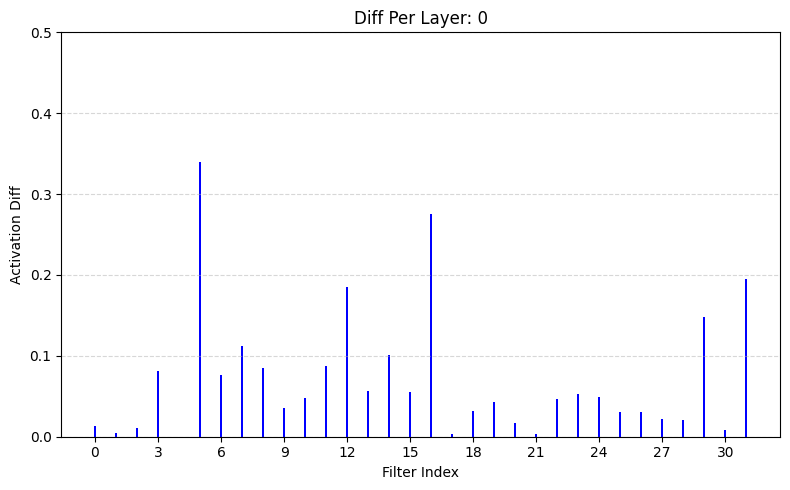

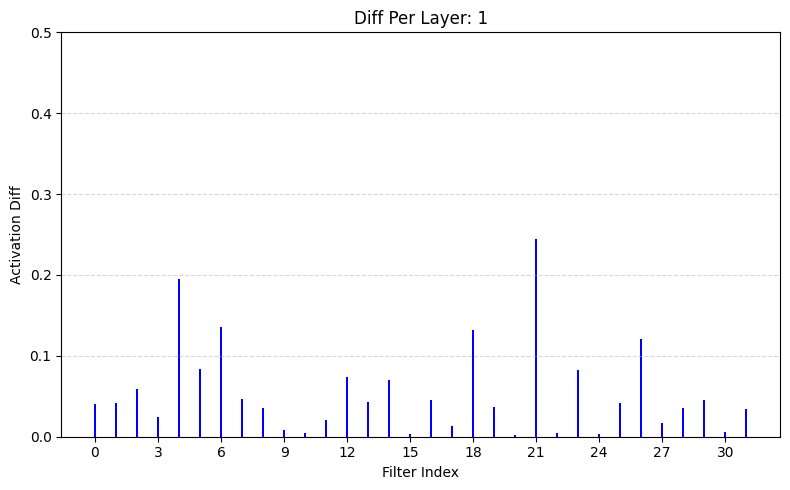

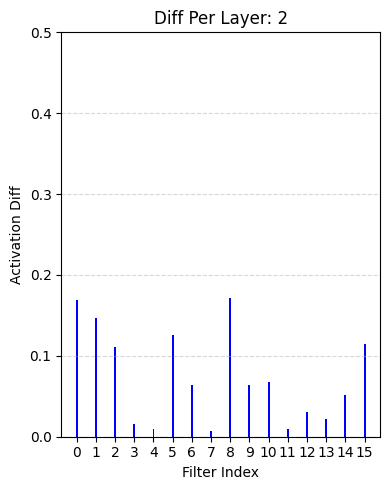

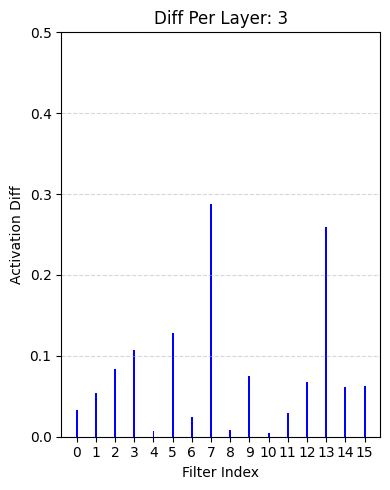

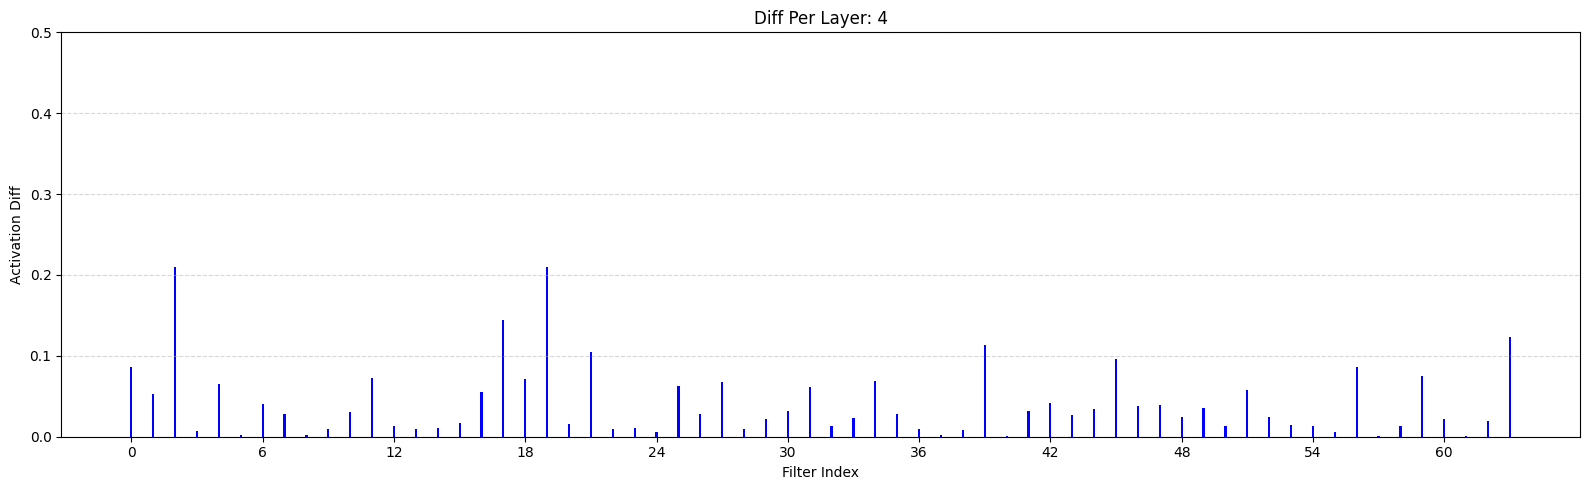

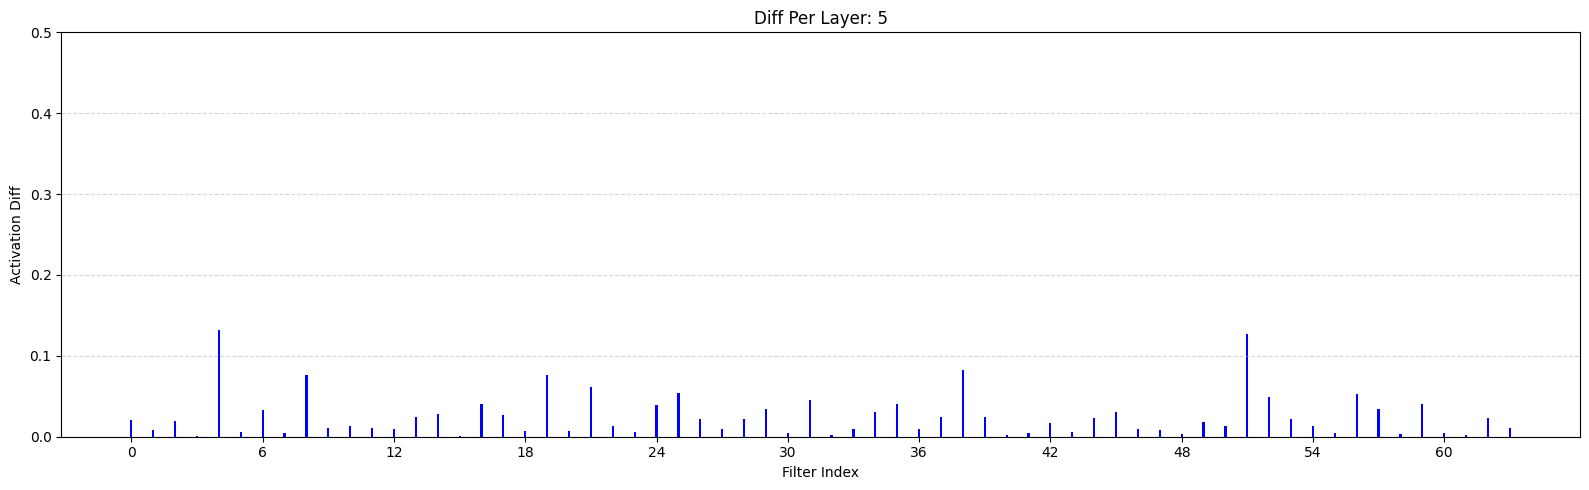

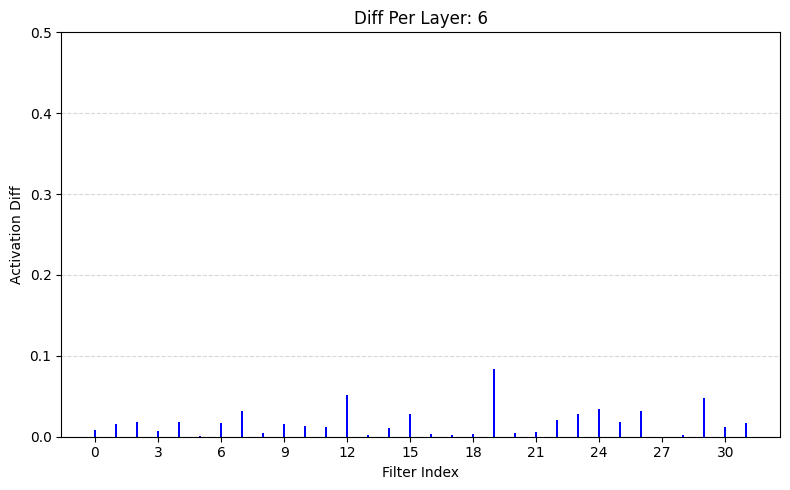

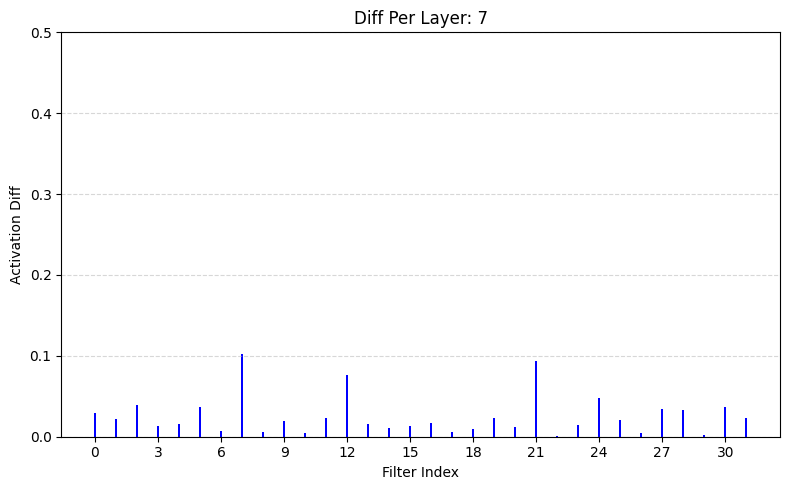

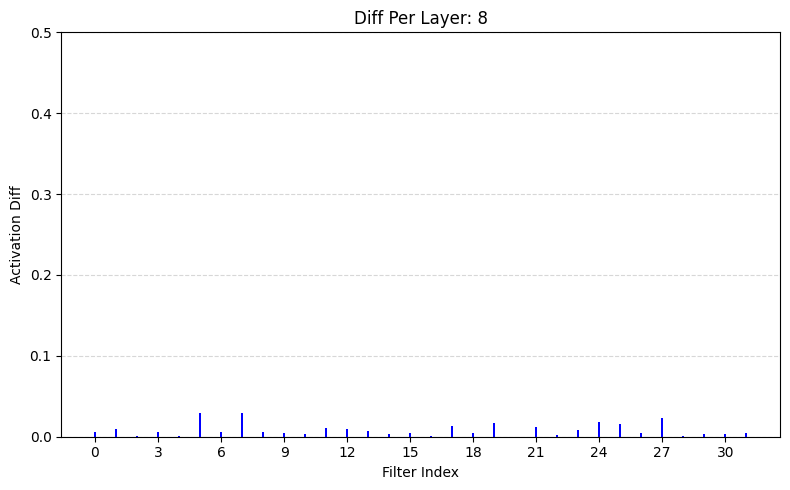

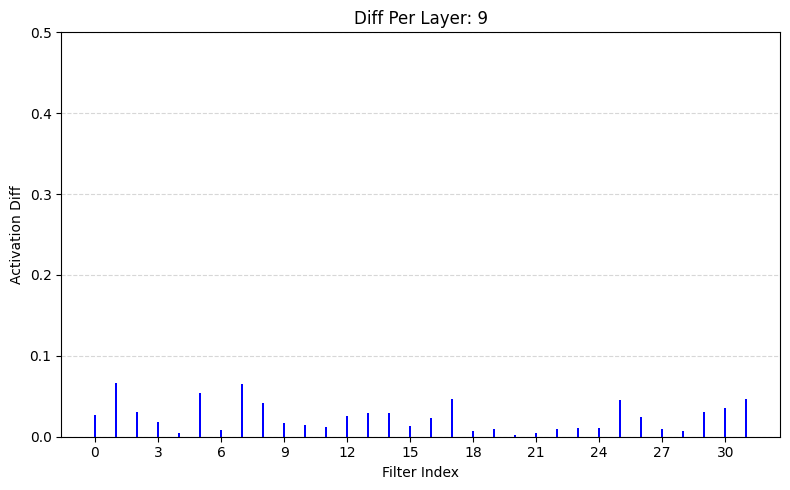

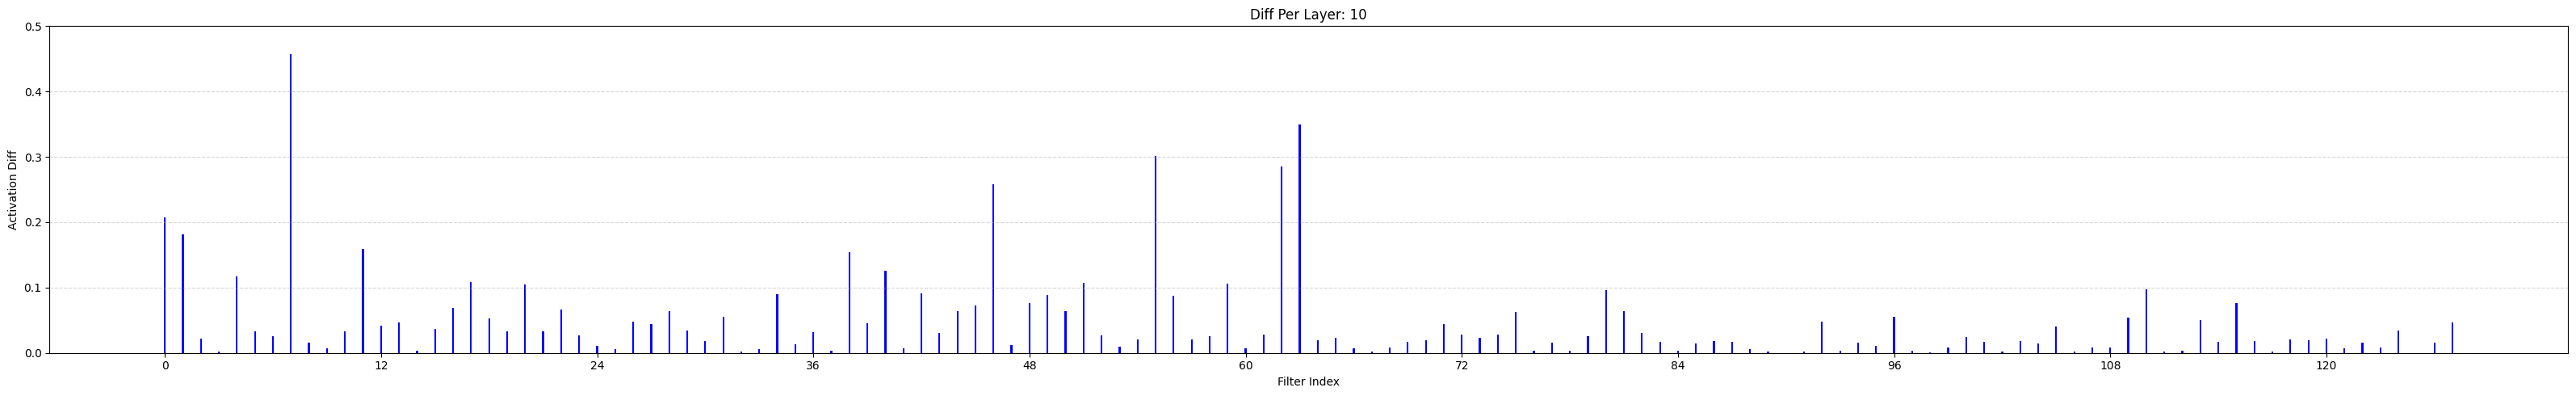

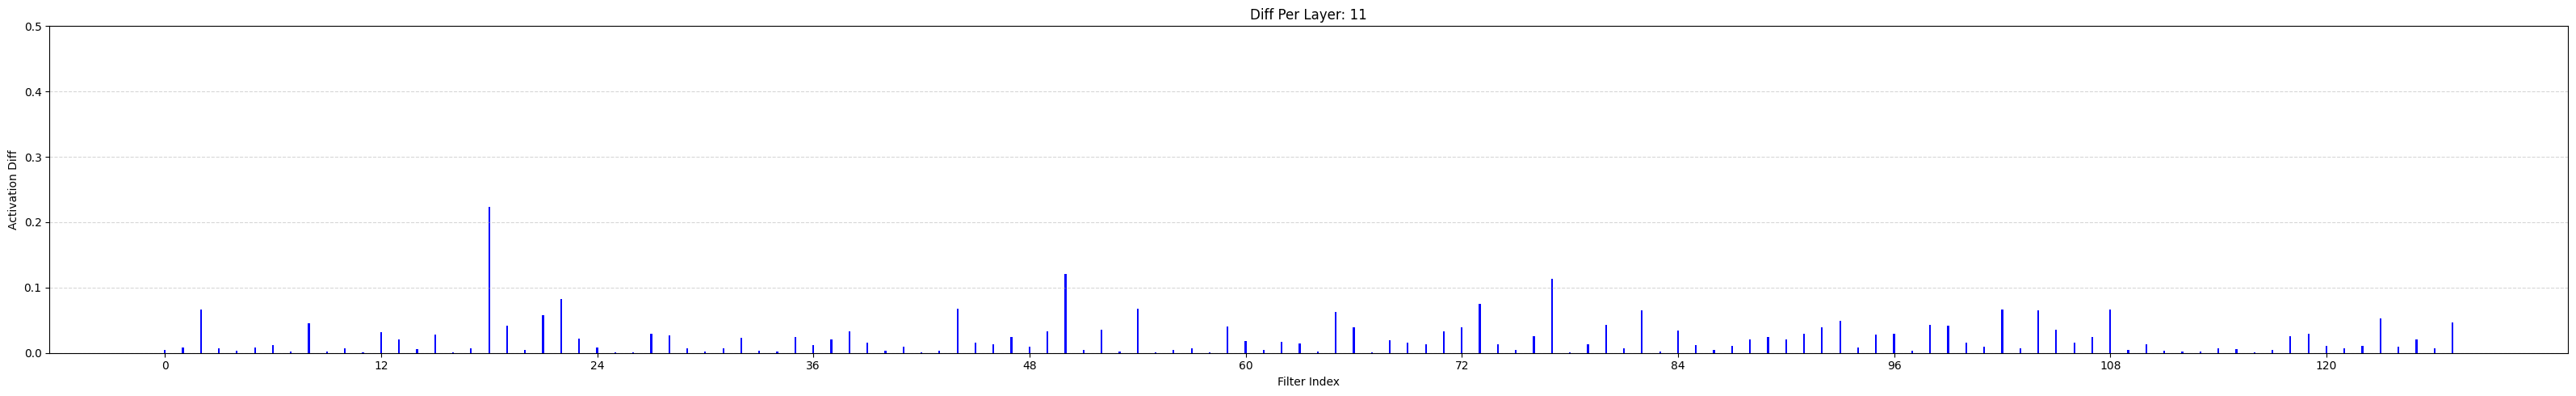

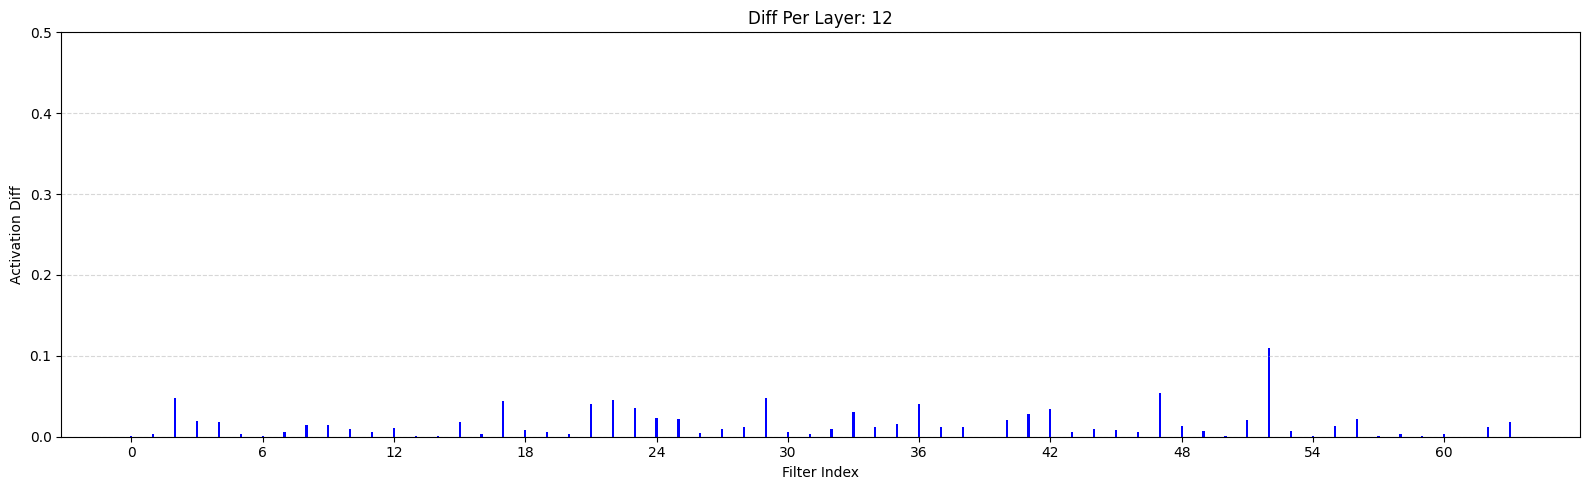

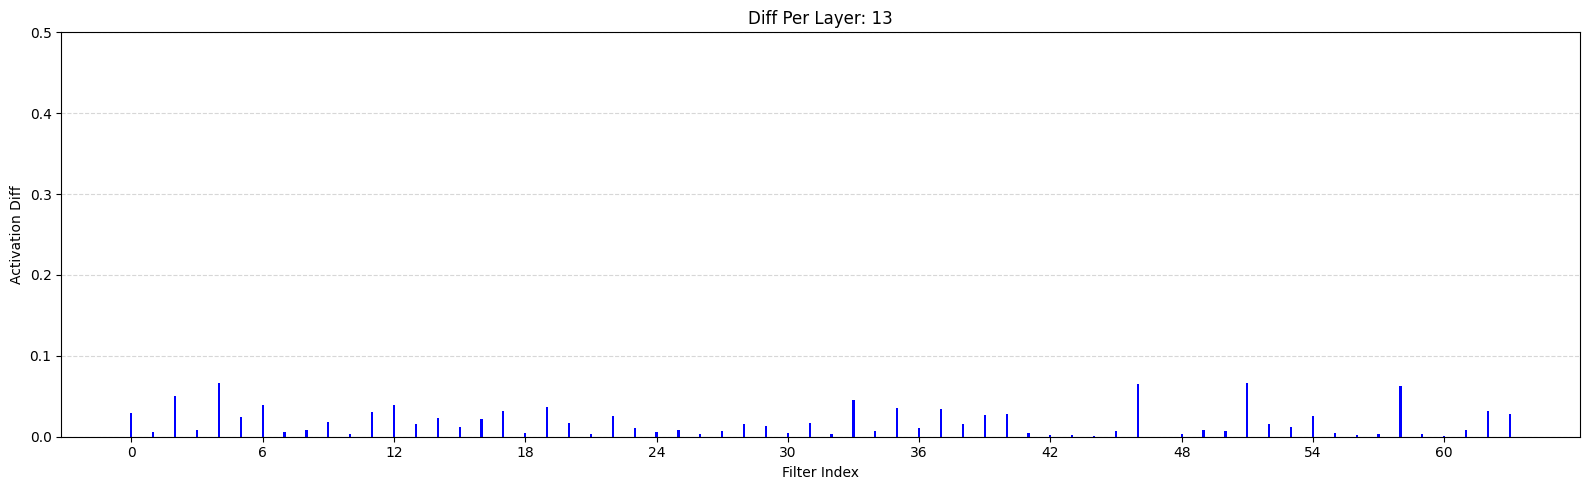

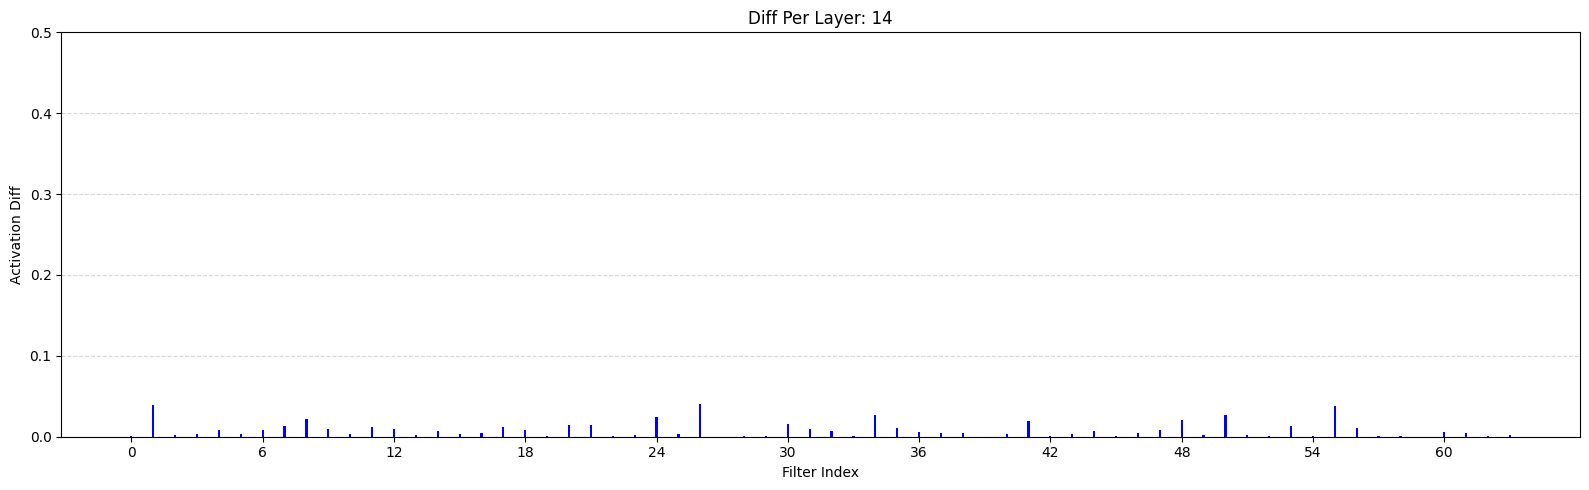

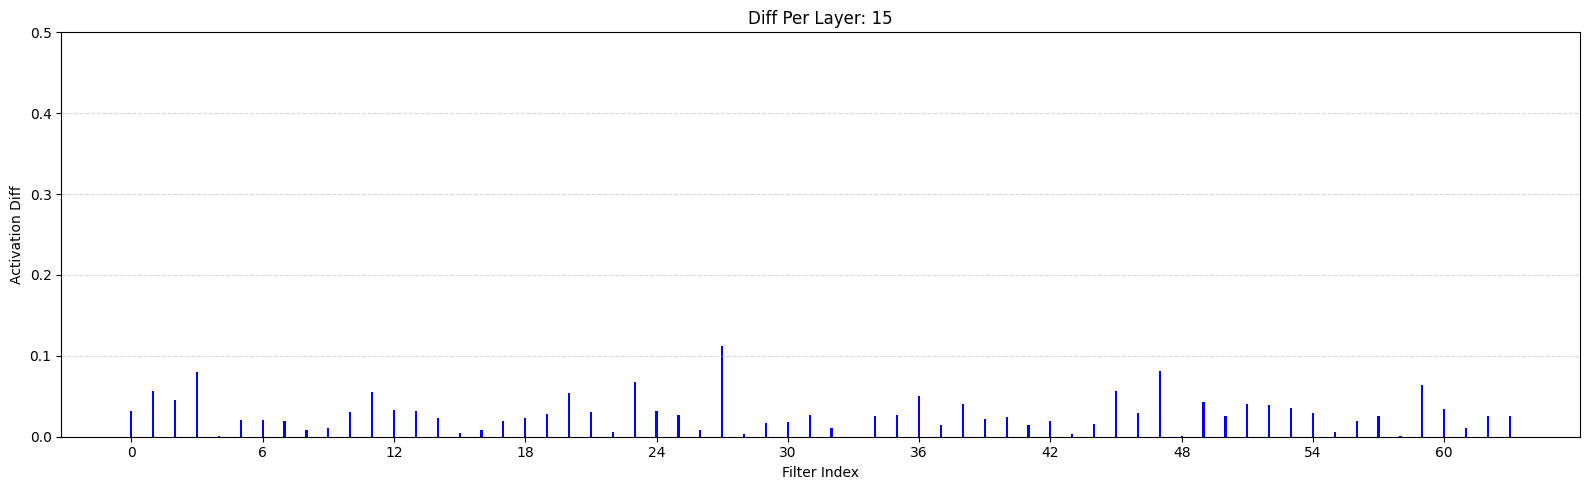

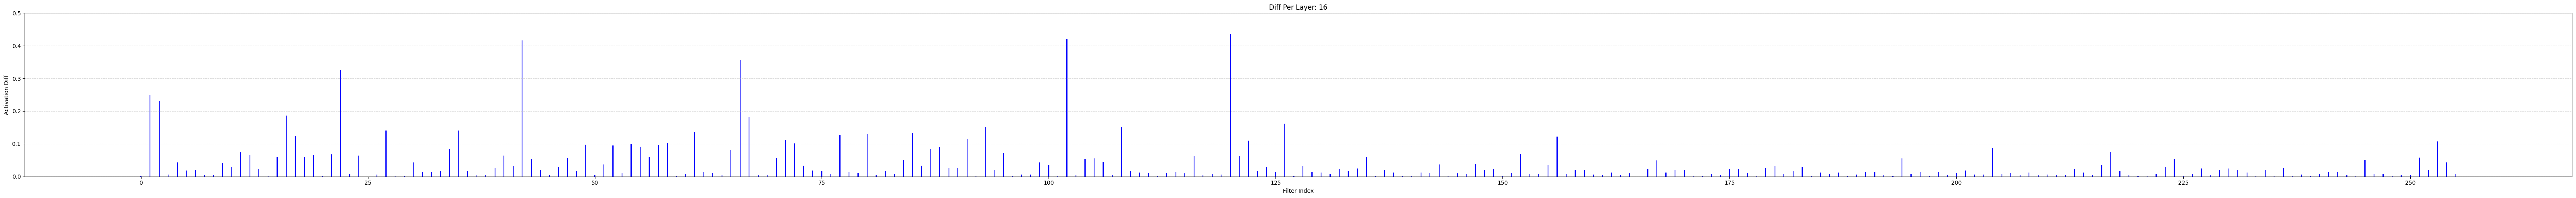

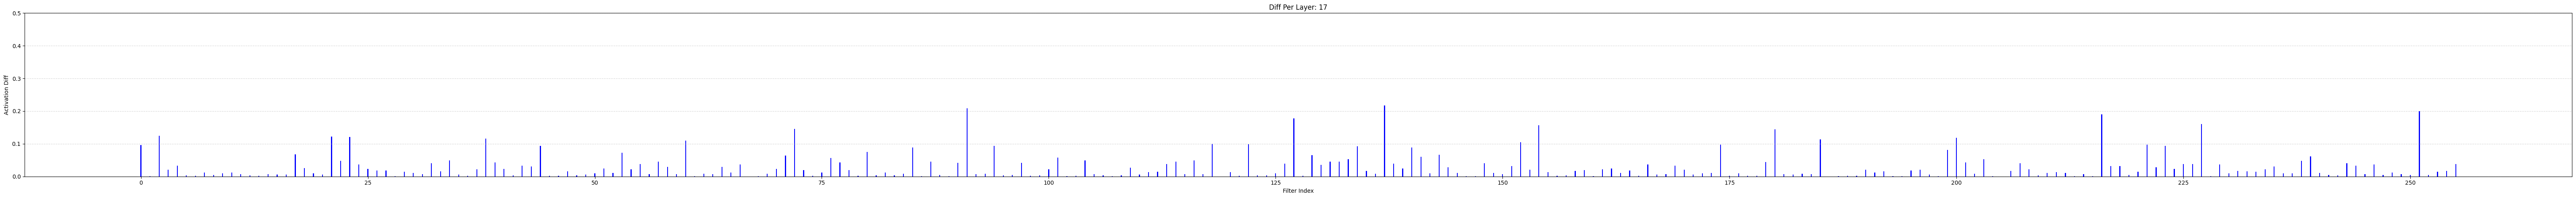

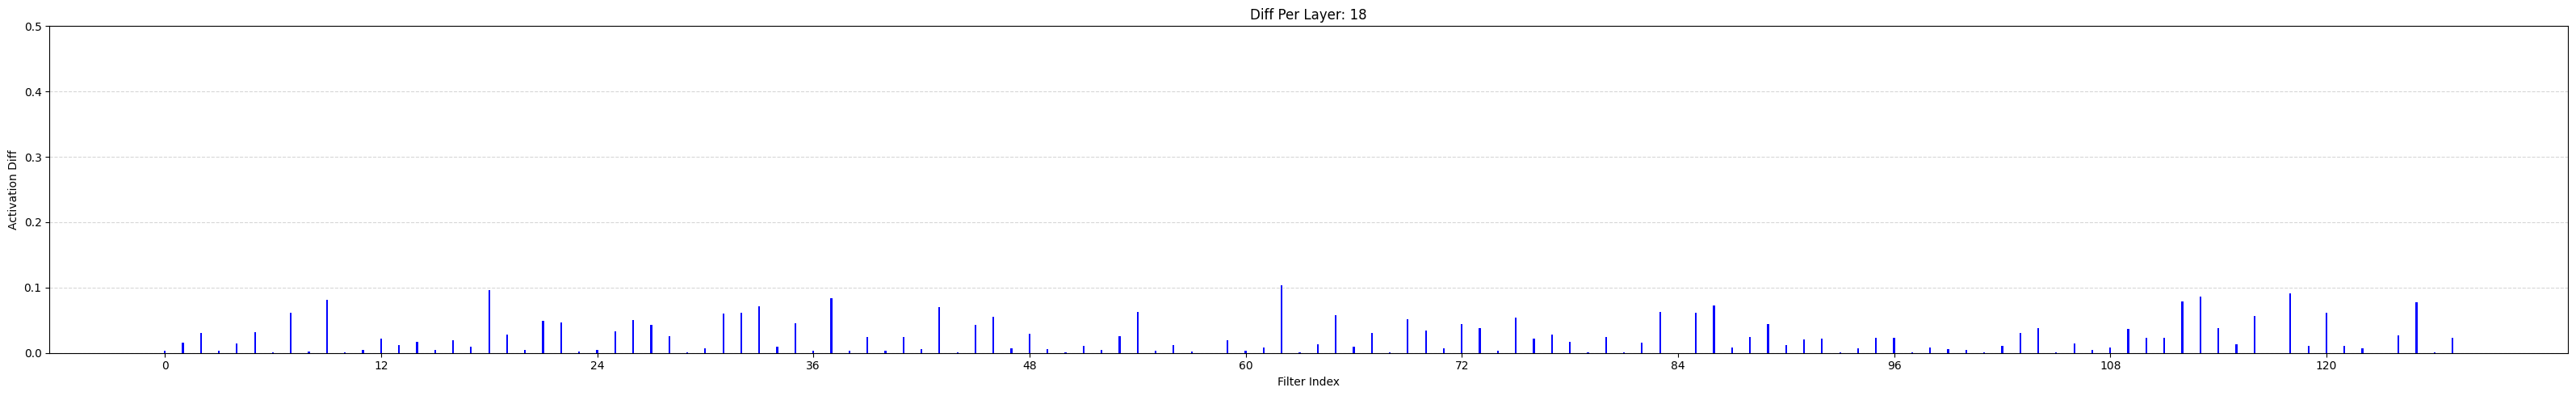

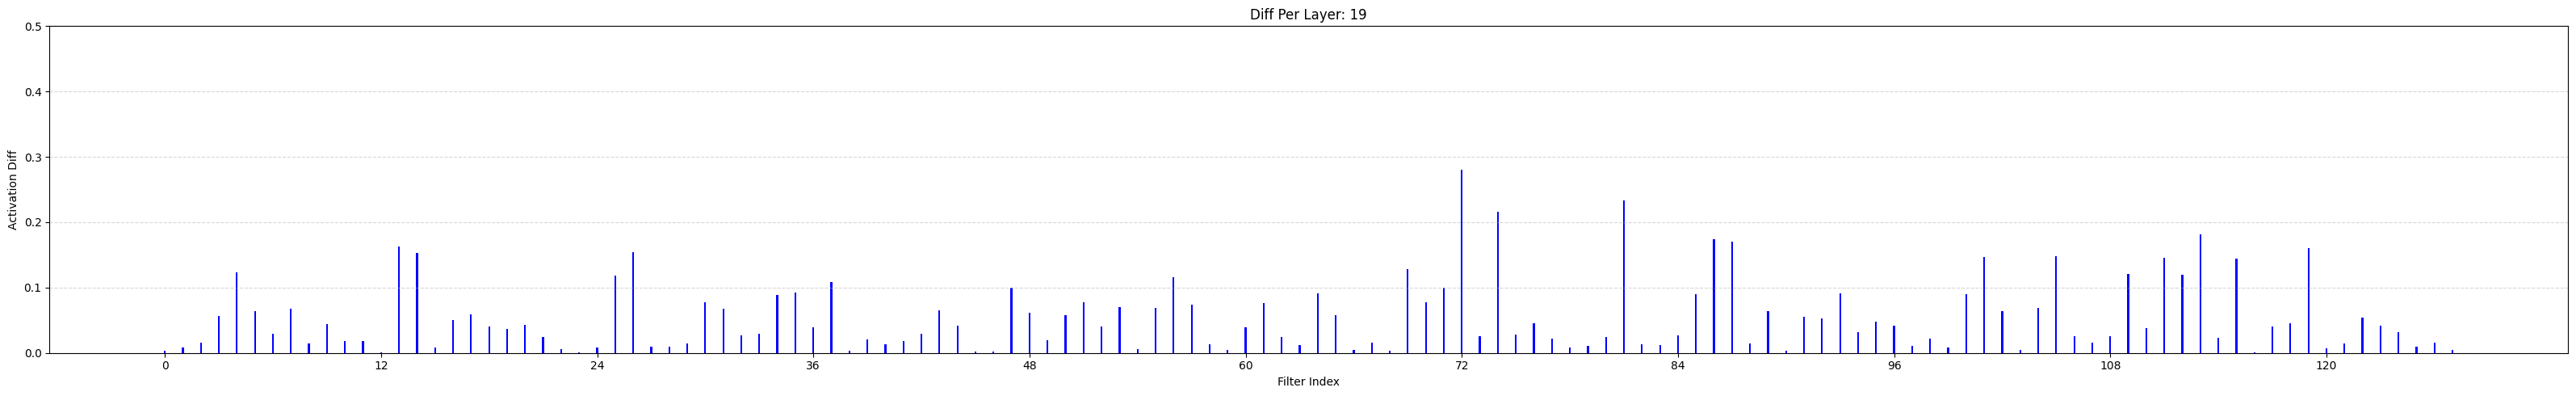

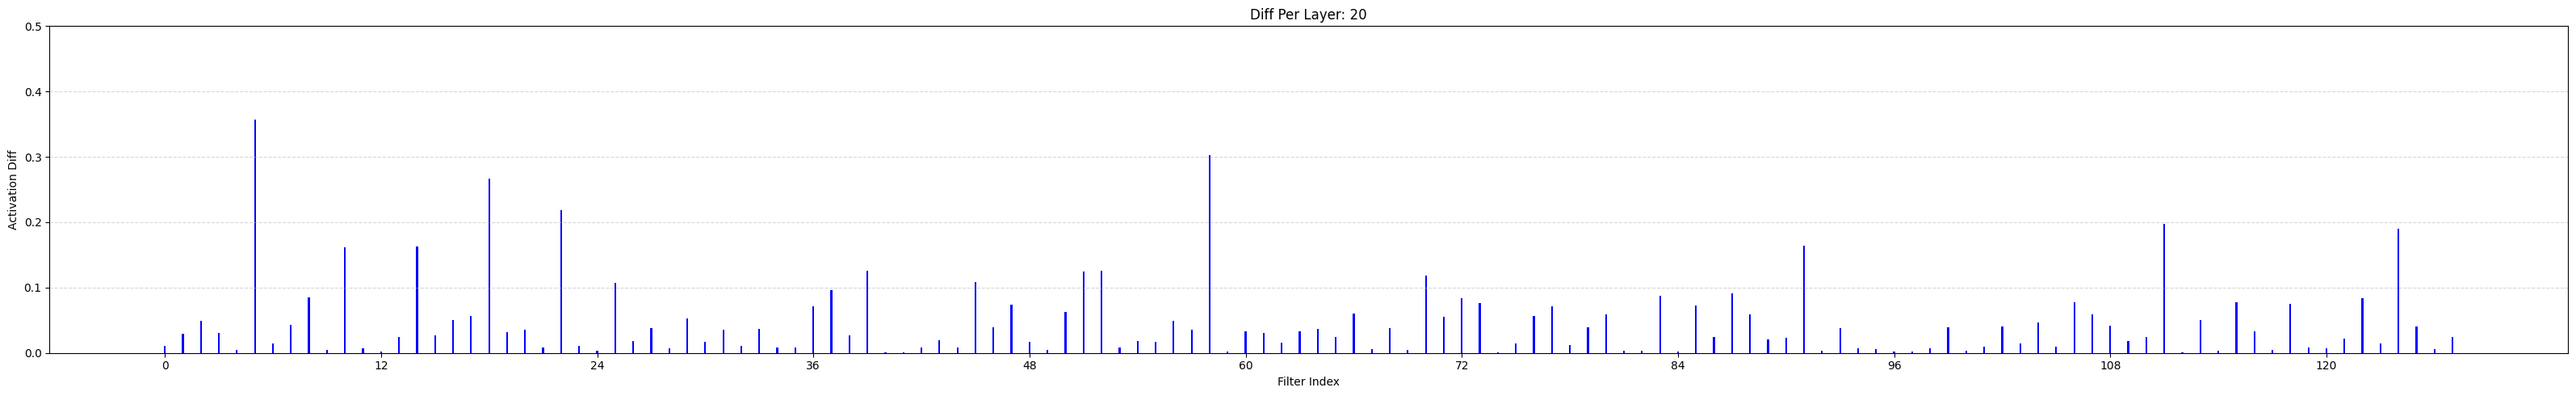

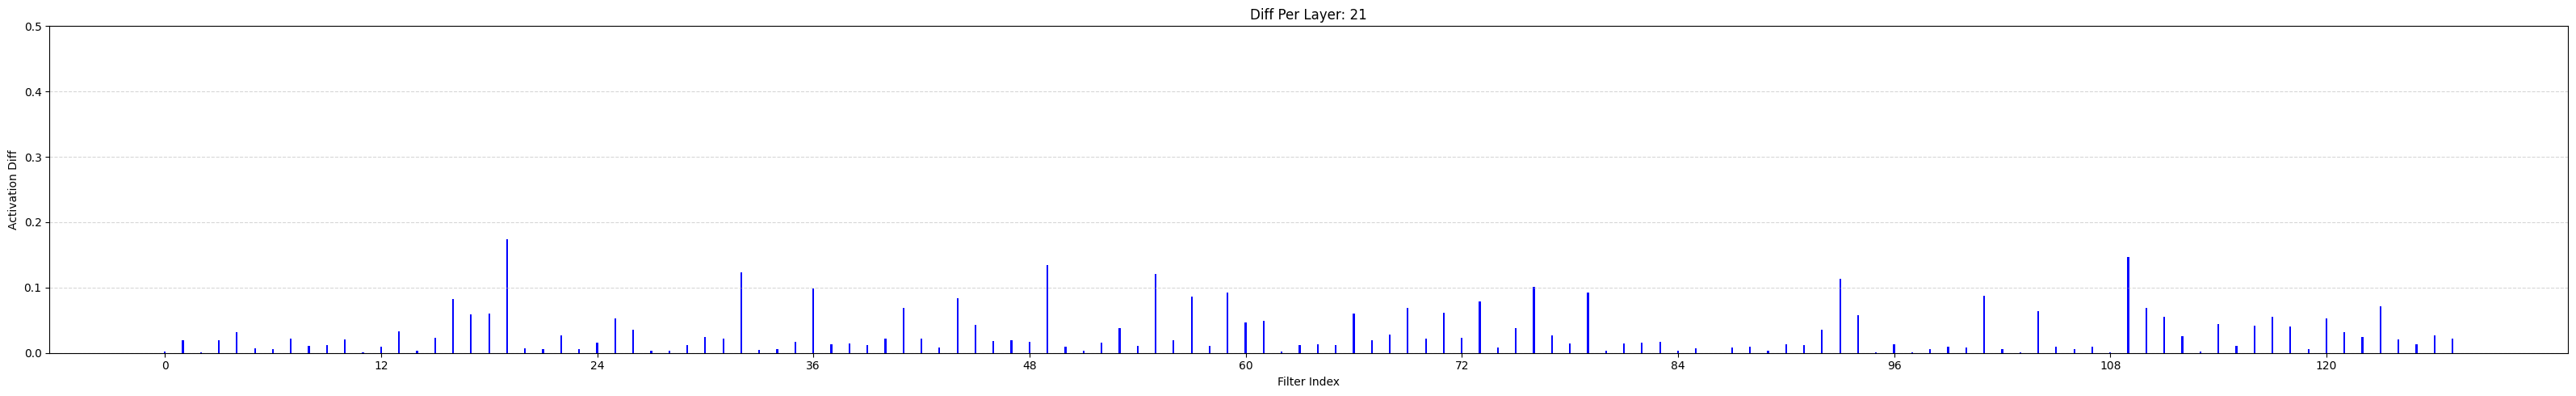

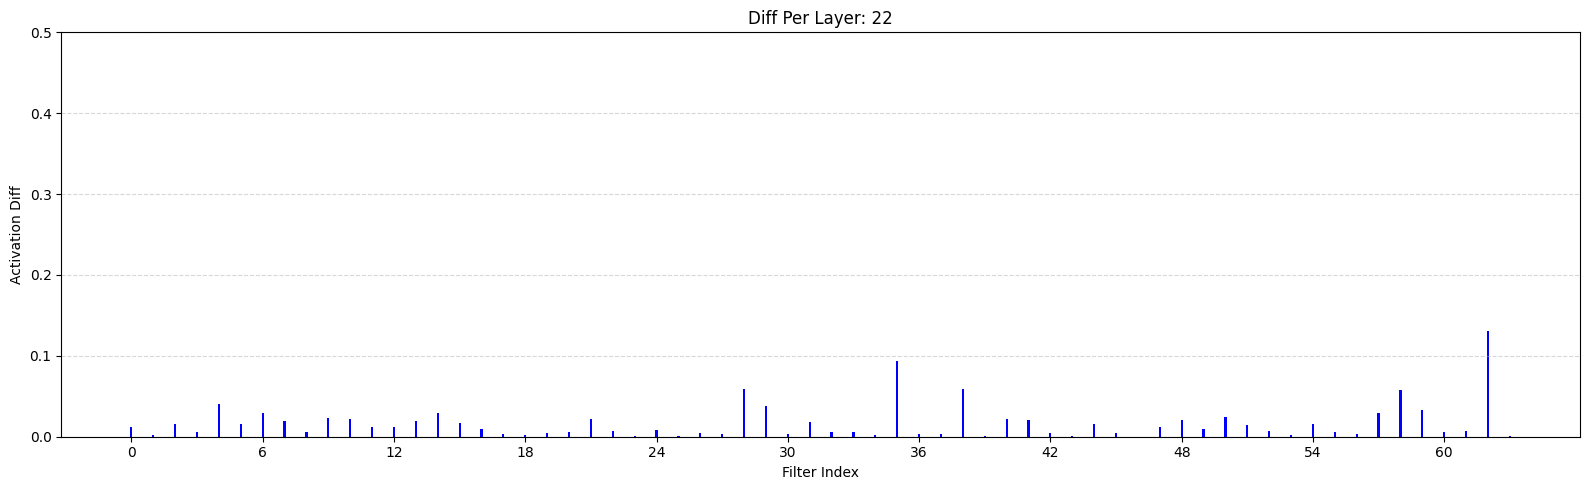

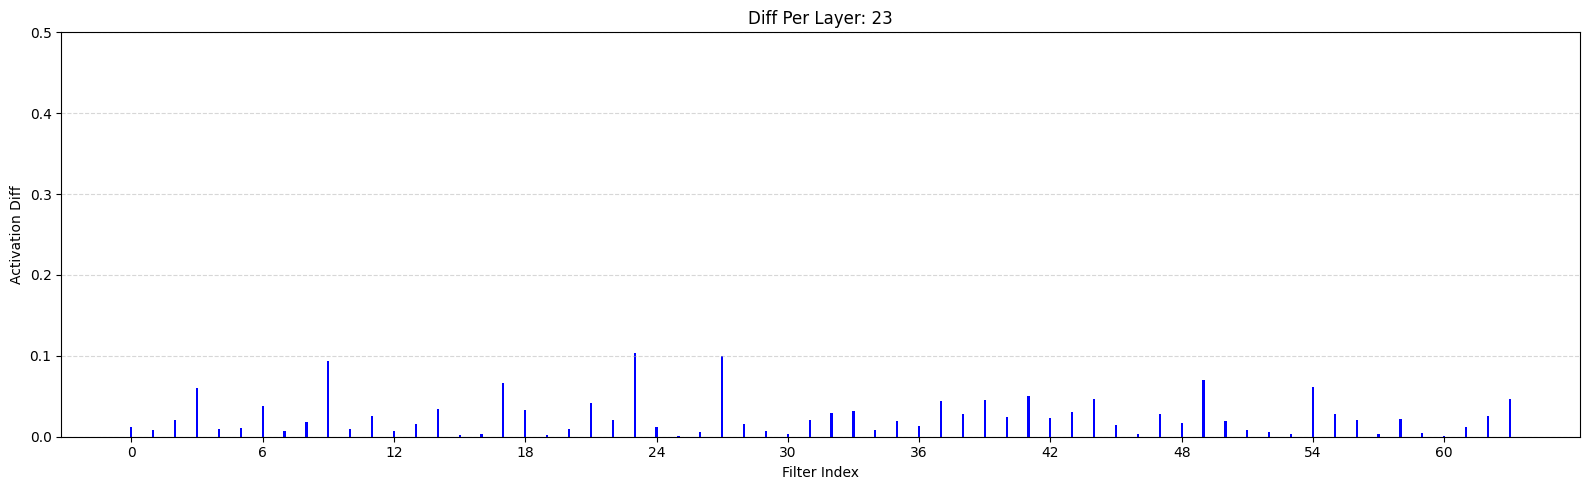

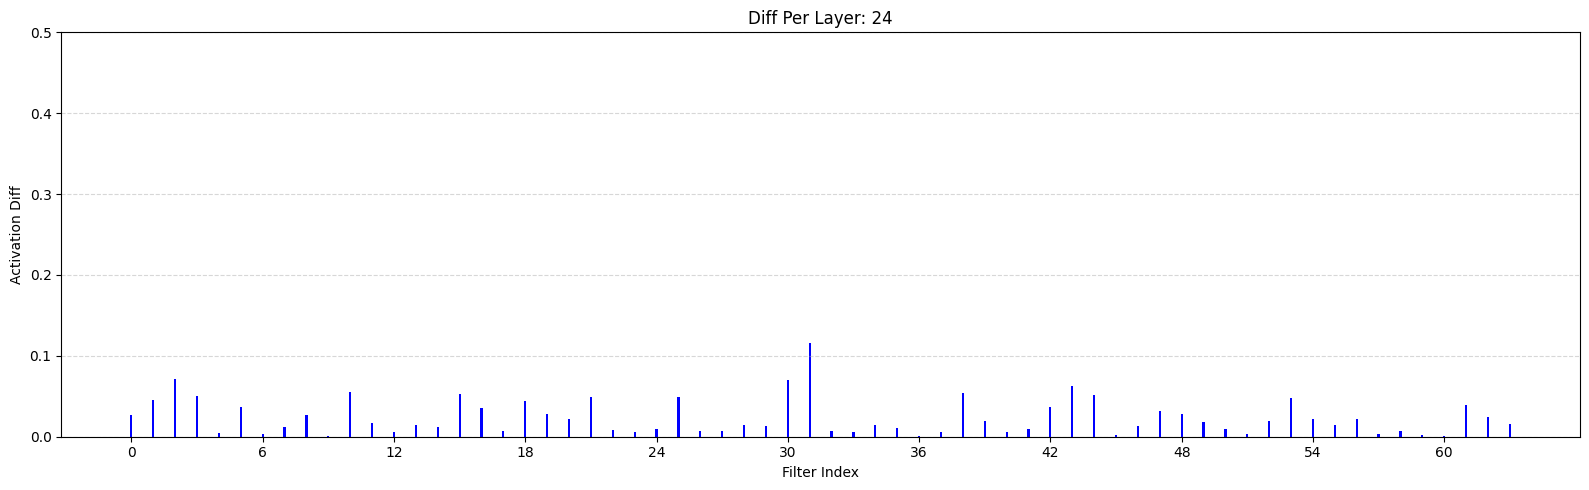

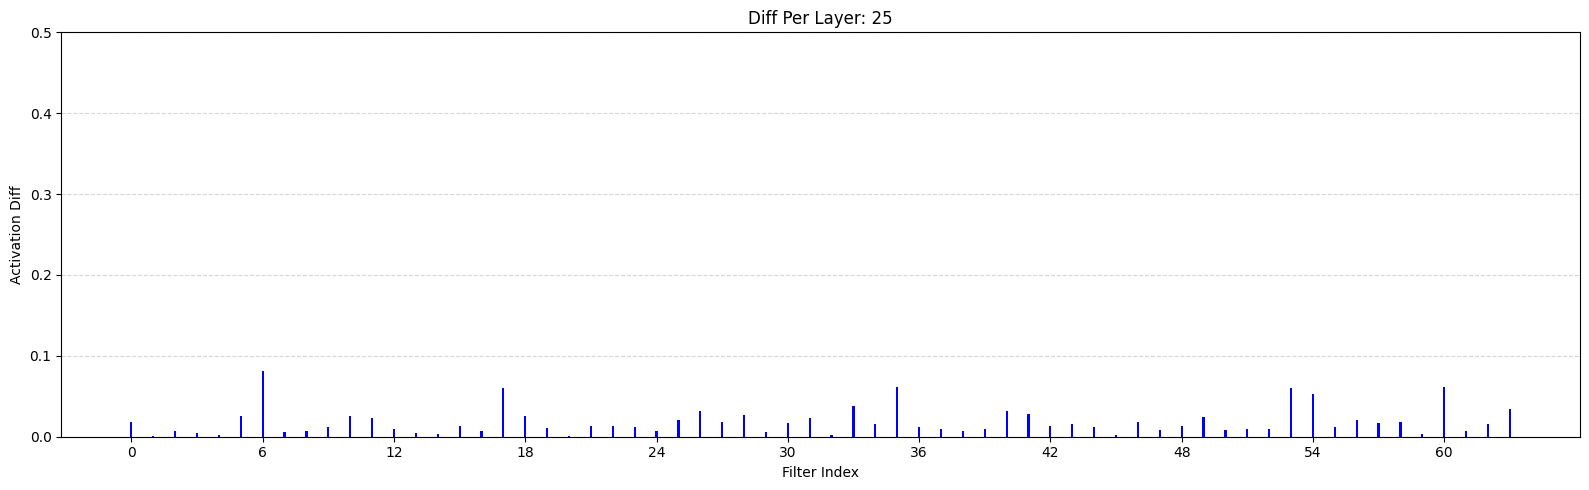

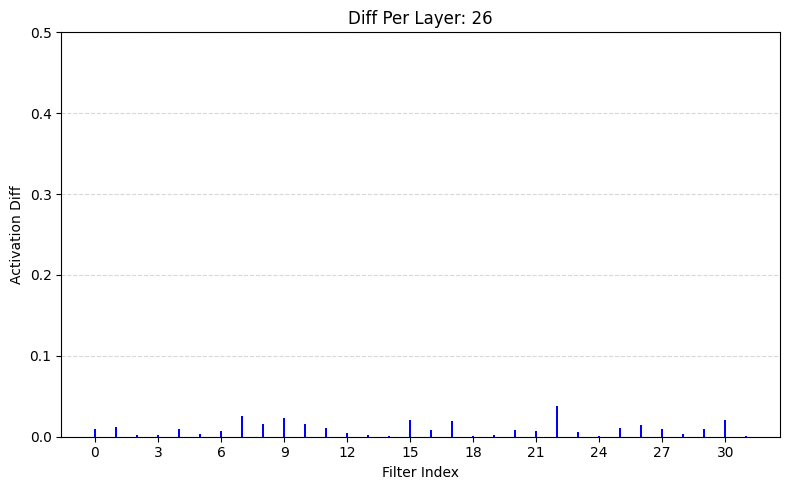

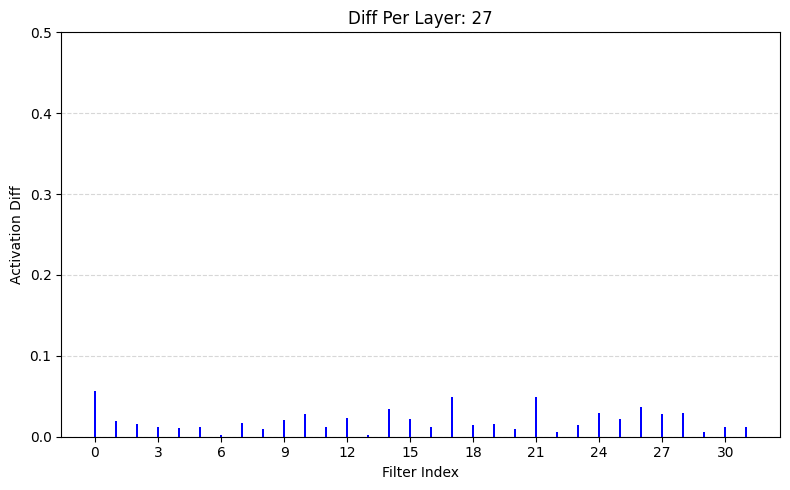

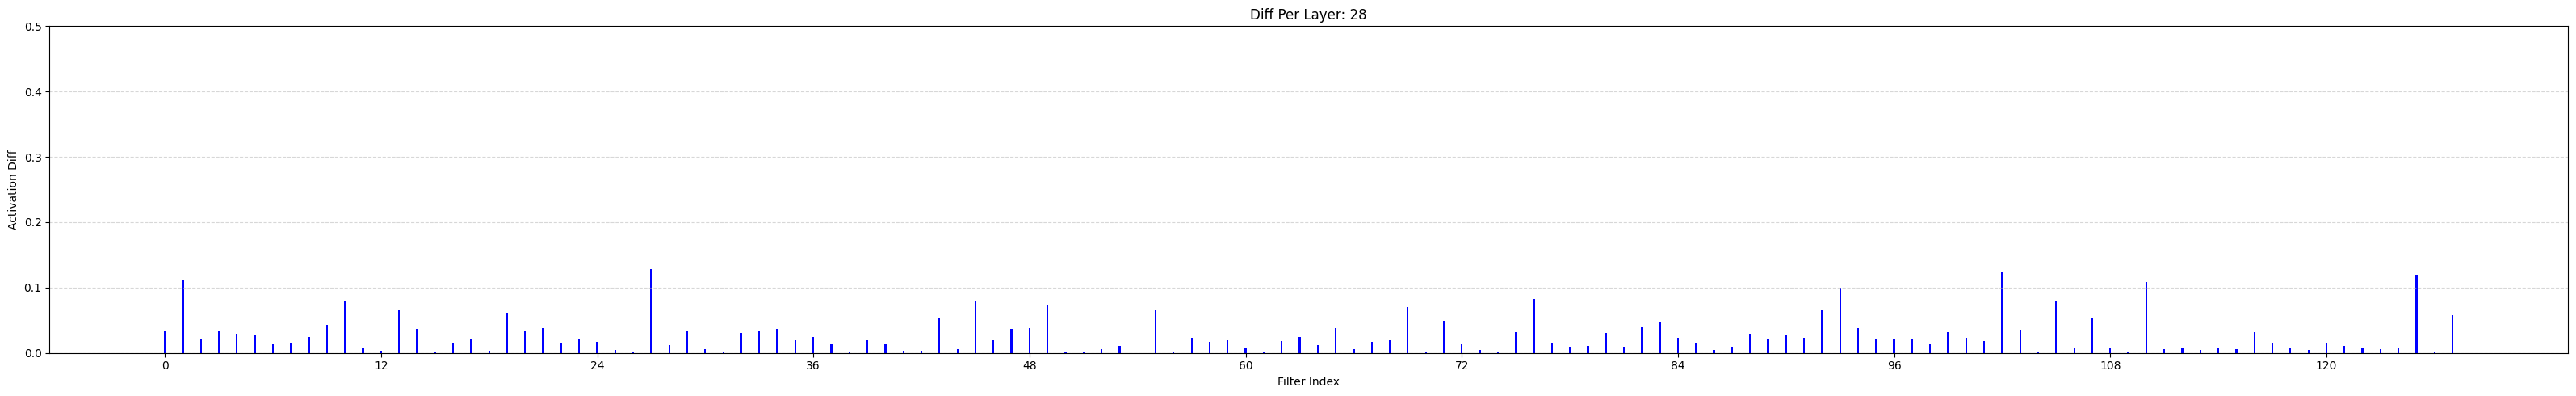

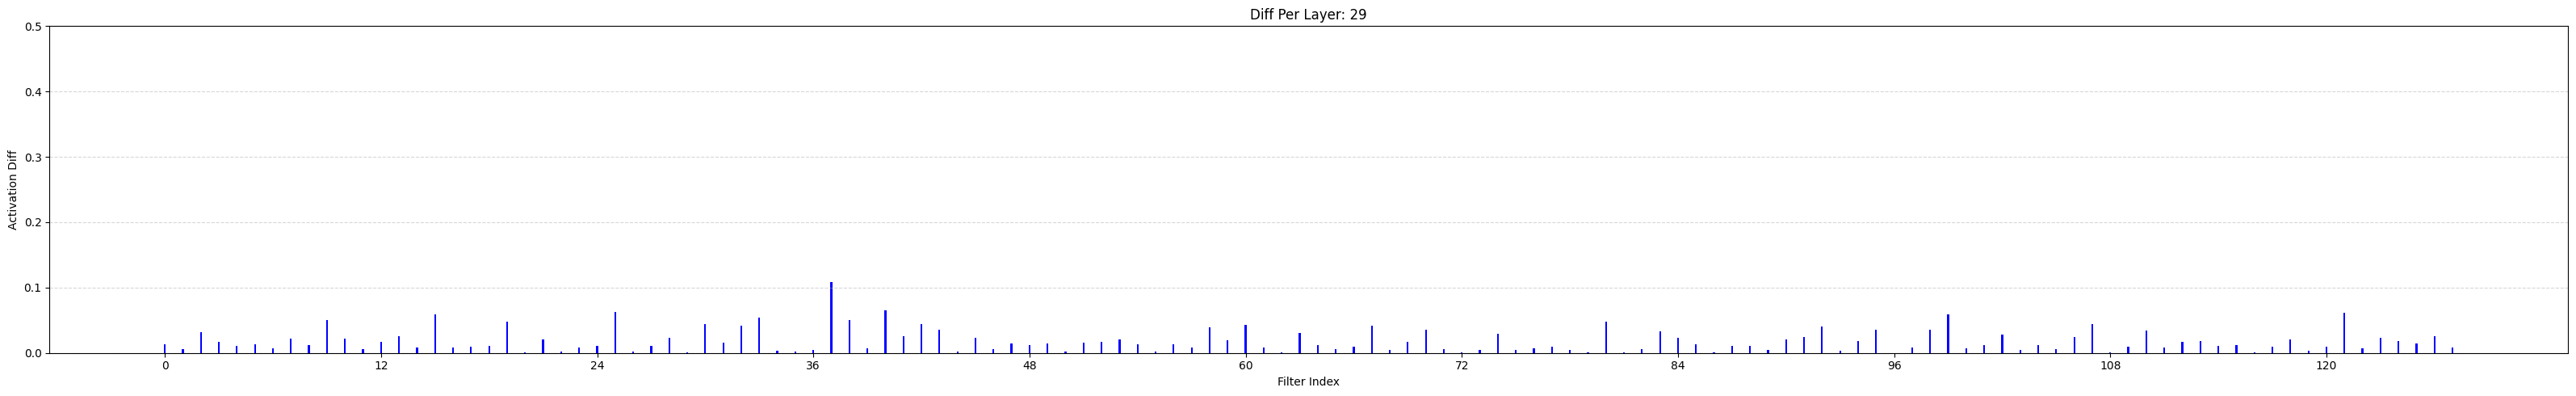

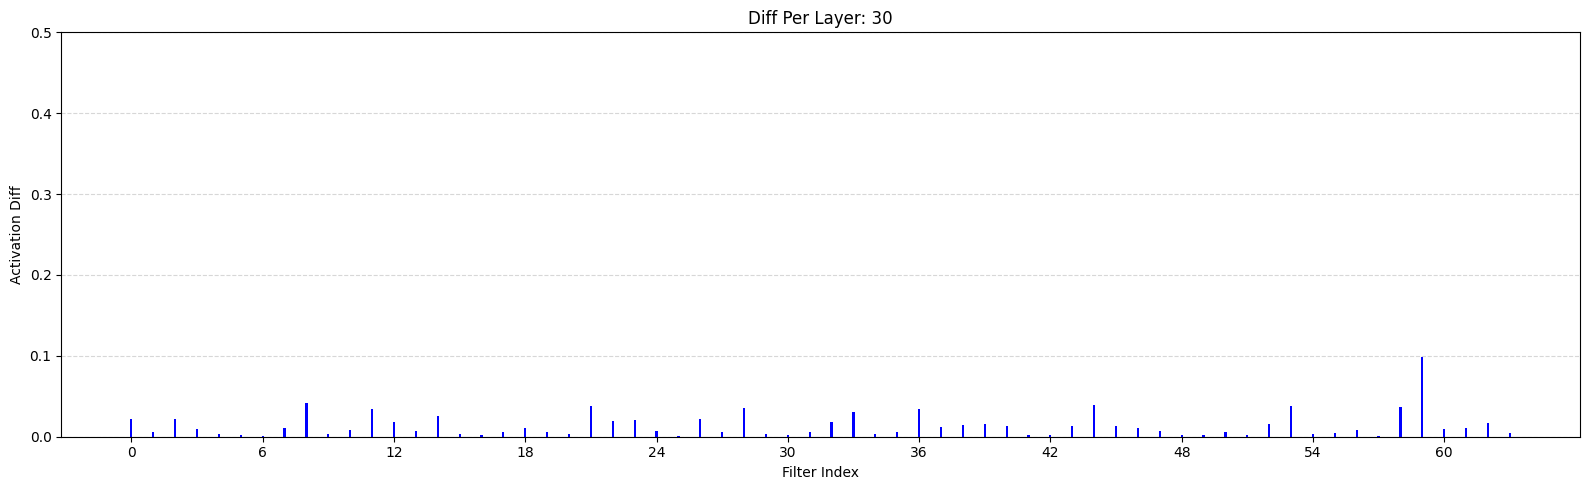

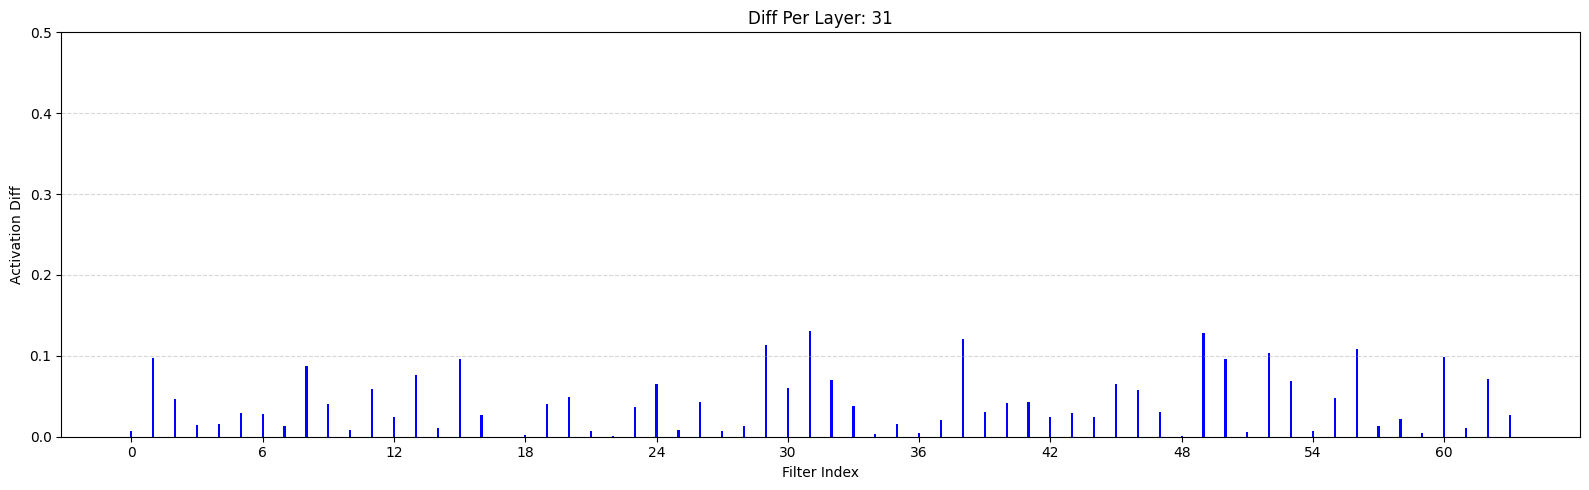

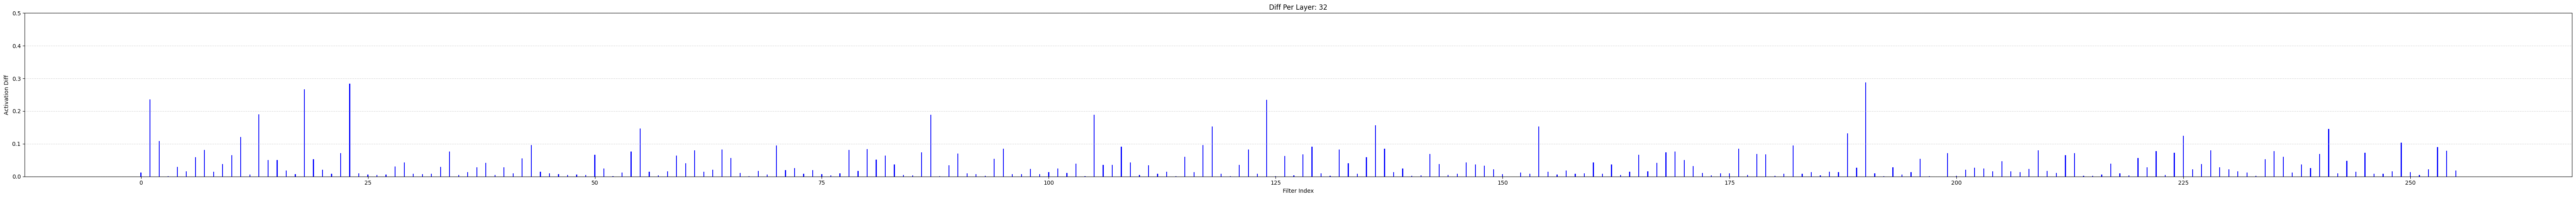

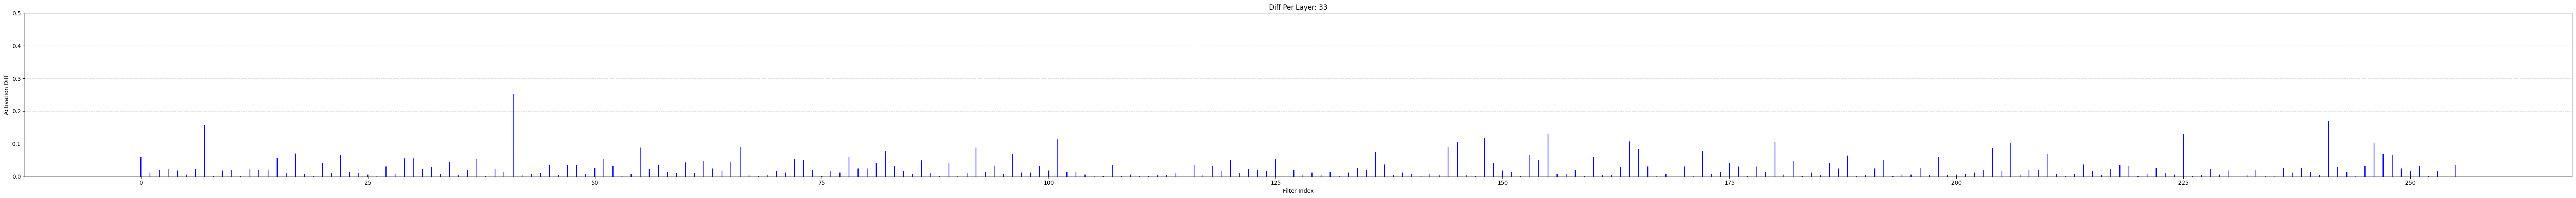

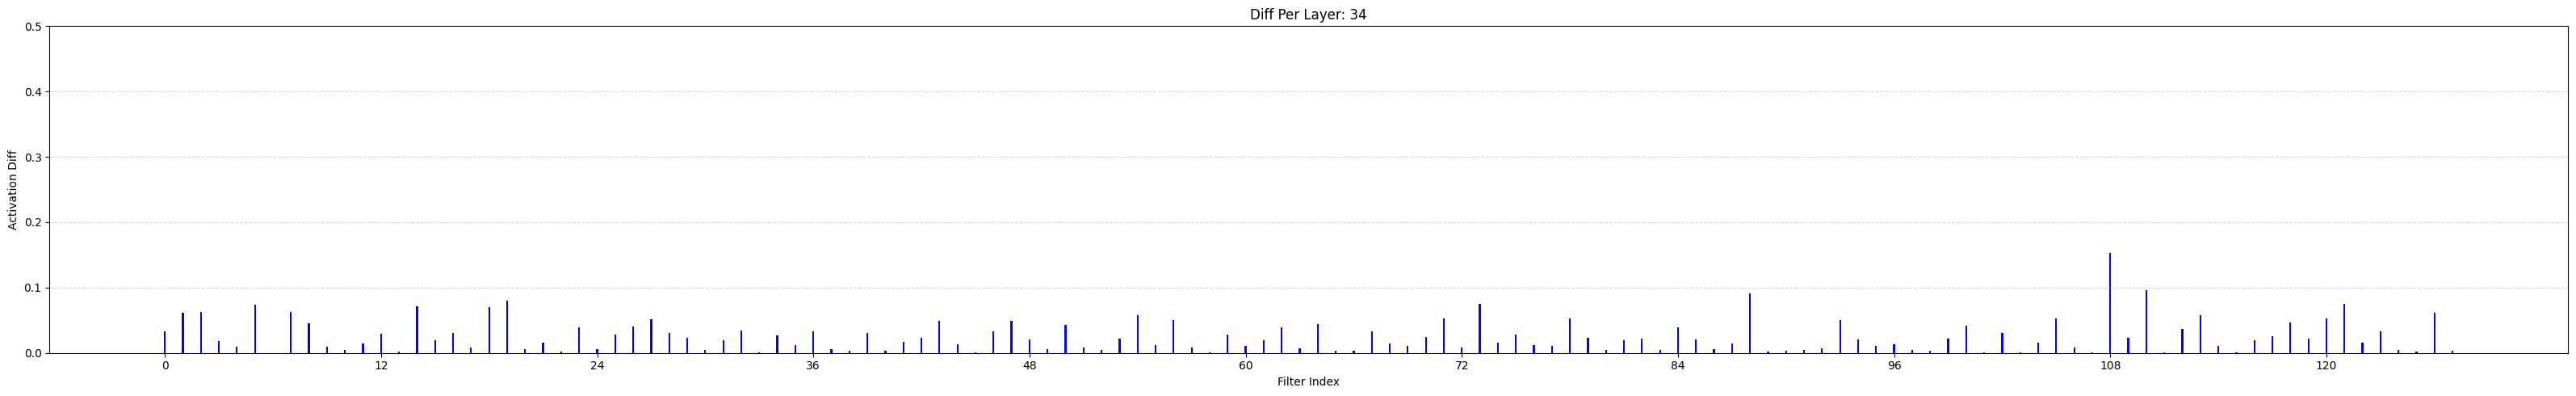

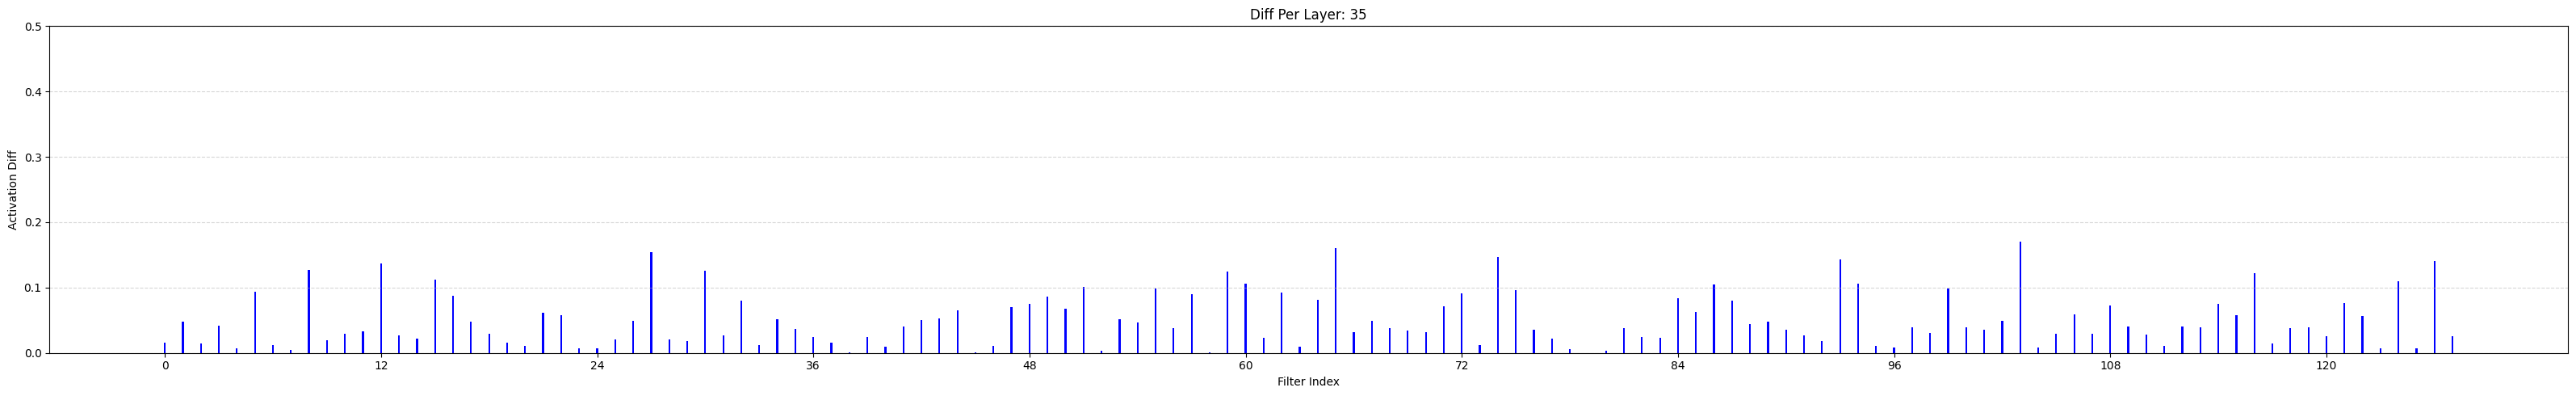

In [ ]:
diff_activation = (origin_activation - attack_activation).abs()
diff_activation_num = [diff_activation[row, torch.nonzero(diff_activation[row, :]).t().squeeze(0)].cpu().numpy() for row in range(diff_activation.size(0))]


for row in range(len(diff_activation_num)):
	filter_num = len(diff_activation_num[row])
	# plt.figure(figsize=(filter_num/4, 5))
	plt.bar(range(filter_num), diff_activation_num[row], color='blue', alpha=1, width=0.1)
	plt.ylim(0, 0.5)
	plt.title(f'Diff Per Layer: {row}')
	plt.xlabel('Filter Index')
	plt.ylabel('Activation Diff')
	plt.xticks(np.arange(0, filter_num, max(1, filter_num//10)))  # 自动调整刻度密度
	plt.grid(axis='y', linestyle='--', alpha=0.5)
	plt.tight_layout()
	plt.show()

In [ ]:
# filter_num用于设置该层的卷积核总数,每个卷积核出一张图,可以通过查看模型结构来得到

filter_num = 384
for filter_idx in range(0, filter_num):
	FV.visualize_opt(filter_idx=filter_idx, lr=0.002, opt_steps=20, blur=5, cmd=False)

In [ ]:
backbone_c2f3 = yolo_nn[layer_map['backbone_c2f3']]
print(backbone_c2f3)

FV = FilterAnalyzer(
	model=yolo,
 	module=backbone_c2f3,
	target_layer_path='backbone_c2f3.cv1.conv',
	parent_path='backbone_c2f3',
	size=640,
	upscaling_steps=20,
	upscaling_factor=1.2
)

filter_num = 384	# **
for filter_idx in range(0, filter_num):
	FV.visualize_opt(filter_idx=filter_idx, lr=0.002, opt_steps=20, blur=5, cmd=False)

In [ ]:
backbone_c2f1 = yolo_nn[layer_map['backbone_c2f1']]
print(backbone_c2f1)

FV = FilterAnalyzer(
	model=yolo,
 	module=backbone_c2f1,
	target_layer_path='backbone_c2f1.cv1.conv',
	parent_path='backbone_c2f1',
	size=56,
	upscaling_steps=20,
	upscaling_factor=1.2
)

filter_num = 32	# **
for filter_idx in range(0, filter_num):
	FV.visualize_opt(filter_idx=filter_idx, lr=0.002, opt_steps=20, blur=5, cmd=False)

In [ ]:
neck_c2f1 = yolo_nn[layer_map['neck_c2f1']]
print(neck_c2f1)

FV = FilterAnalyzer(
	model=yolo,
 	module=neck_c2f1,
	target_layer_path='neck_c2f1.cv1.conv',
	parent_path='neck_c2f1',
	size=640,
	upscaling_steps=20,
	upscaling_factor=1.2
)

filter_num = 32	# **
for filter_idx in range(0, filter_num):
	FV.visualize_opt(filter_idx=filter_idx, lr=0.002, opt_steps=20, blur=5, cmd=False)